In [1]:
import re
import os 
import datetime
from math import log
import csv
import pprint
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from pandas.io.parsers import read_csv
pd.set_option('max_colwidth',120)
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
from __future__ import division

%matplotlib inline

pp = pprint.PrettyPrinter()

In [2]:
#bashcommand='pwd'

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=10)

In [4]:
indices = es.cat.indices(index=['jobs_archive_2016-05-14','jobs_archive_2016-05-15','jobs_archive_2016-05-16'], h="index", request_timeout=10).split('\n')
indices = sorted(indices)
indices = [x.replace(" ", "") for x in indices if x != '']

In [5]:
print (indices)

['jobs_archive_2016-05-14', 'jobs_archive_2016-05-15', 'jobs_archive_2016-05-16']


In [6]:
ss={
 "query": { "prefix": { "computingsite": "IN2P3-CC" } 
}, "_source": ["pandaid","batchid","computingsite","computingelement","corecount","creationtime","starttime","endtime",
   "cpuconsumptiontime","wall_time","modificationhost","maxrss","maxpss"]
#    ,"size": 5
    }



#ss= {"query": { "match_all": {} },"size": 10000} 
print (ss)



{'_source': ['pandaid', 'batchid', 'computingsite', 'computingelement', 'corecount', 'creationtime', 'starttime', 'endtime', 'cpuconsumptiontime', 'wall_time', 'modificationhost', 'maxrss', 'maxpss'], 'query': {'prefix': {'computingsite': 'IN2P3-CC'}}}


In [7]:
#res = es.search(index='jobs_archive_2016-06-26', body=ss, filter_path=['hits.hits._source'],request_timeout=12000)

In [8]:
res=es.search(index=indices, body=ss,request_timeout=12000)
#print (res)
len(res)
#print (res)

4

In [9]:
 #res.get('hits').get('hits')

In [10]:
scroll=scan(es,index=indices, query=ss,scroll=u'30m', raise_on_error=True, preserve_order=False, size=200000,request_timeout=300)

In [11]:
c=1
list2=[]
for name in scroll:
 a=name.get('_source')
 list2.append(a)
 c=c+1
print (c)
type(list2)
dfu = pd.DataFrame(list2)
 
#dfu.batchid.count()
dfu.head()
 
 

52398


,batchid,computingelement,computingsite,corecount,cpuconsumptiontime,creationtime,endtime,maxpss,maxrss,modificationhost,pandaid,starttime,wall_time
0,6306615,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,11720,2016-05-13T16:24:10,2016-05-13T22:35:13,1879236.0,1898340.0,ccwsge0225,2856870195,2016-05-13T19:13:05,12128
1,6307078,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,11397,2016-05-13T16:24:10,2016-05-13T22:31:56,1942034.0,2013896.0,ccwsge0696,2856870201,2016-05-13T19:14:03,11873
2,6324251,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,1465,2016-05-13T22:48:34,2016-05-13T23:18:41,1513591.0,1529472.0,ccwsge0805,2857222768,2016-05-13T22:49:46,1735
3,6307264,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,11381,2016-05-13T16:24:10,2016-05-13T22:31:47,1898791.0,1920312.0,ccwsge0253,2856870200,2016-05-13T19:14:02,11865
4,6294212,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,9636,2016-05-13T16:24:11,2016-05-13T19:48:43,1994656.0,2010472.0,ccwsge0809,2856870229,2016-05-13T17:01:41,10022


In [12]:
dfu.groupby(dfu.computingelement).computingsite.count()

computingelement
IN2P3-CC-T3_MCORE             255
IN2P3-CC-T3_VM01             1151
IN2P3-CC-all-ce-sge-long    39006
IN2P3-CC_MCORE_HIMEM         6491
IN2P3-CC_VVL                 1567
cccreamceli01.in2p3.fr       3172
cccreamceli05.in2p3.fr        647
cccreamceli07.in2p3.fr          6
Name: computingsite, dtype: int64

In [13]:
dfu.groupby(dfu.computingsite).count()

,batchid,computingelement,corecount,cpuconsumptiontime,creationtime,endtime,maxpss,maxrss,modificationhost,pandaid,starttime,wall_time
computingsite,,,,,,,,,,,,
IN2P3-CC,39006,39651,39748,39753,39753,39753,38934,38934,39753,39753,39006,39753
IN2P3-CC-T3_MCORE,255,255,255,255,255,255,249,249,255,255,255,255
IN2P3-CC-T3_VM01,1151,1157,1149,1157,1157,1157,1148,1148,1157,1157,1151,1157
IN2P3-CC_MCORE_HIMEM,6490,9663,9663,9663,9663,9663,6456,6456,9663,9663,6491,9663
IN2P3-CC_VVL,1567,1569,1569,1569,1569,1569,1565,1565,1569,1569,1567,1569


In [14]:


#rint (res.get('hits').get('hits'))
#list.head()
#res[0]
#res['total']

In [15]:
dfu.head()

,batchid,computingelement,computingsite,corecount,cpuconsumptiontime,creationtime,endtime,maxpss,maxrss,modificationhost,pandaid,starttime,wall_time
0,6306615,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,11720,2016-05-13T16:24:10,2016-05-13T22:35:13,1879236.0,1898340.0,ccwsge0225,2856870195,2016-05-13T19:13:05,12128
1,6307078,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,11397,2016-05-13T16:24:10,2016-05-13T22:31:56,1942034.0,2013896.0,ccwsge0696,2856870201,2016-05-13T19:14:03,11873
2,6324251,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,1465,2016-05-13T22:48:34,2016-05-13T23:18:41,1513591.0,1529472.0,ccwsge0805,2857222768,2016-05-13T22:49:46,1735
3,6307264,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,11381,2016-05-13T16:24:10,2016-05-13T22:31:47,1898791.0,1920312.0,ccwsge0253,2856870200,2016-05-13T19:14:02,11865
4,6294212,IN2P3-CC-all-ce-sge-long,IN2P3-CC,1.0,9636,2016-05-13T16:24:11,2016-05-13T19:48:43,1994656.0,2010472.0,ccwsge0809,2856870229,2016-05-13T17:01:41,10022


In [18]:
 dfu.groupby(['computingsite']).count()

,batchid,computingelement,corecount,cpuconsumptiontime,creationtime,endtime,maxpss,maxrss,modificationhost,pandaid,starttime,wall_time
computingsite,,,,,,,,,,,,
IN2P3-CC,39006,39651,39748,39753,39753,39753,38934,38934,39753,39753,39006,39753
IN2P3-CC-T3_MCORE,255,255,255,255,255,255,249,249,255,255,255,255
IN2P3-CC-T3_VM01,1151,1157,1149,1157,1157,1157,1148,1148,1157,1157,1151,1157
IN2P3-CC_MCORE_HIMEM,6490,9663,9663,9663,9663,9663,6456,6456,9663,9663,6491,9663
IN2P3-CC_VVL,1567,1569,1569,1569,1569,1569,1565,1565,1569,1569,1567,1569


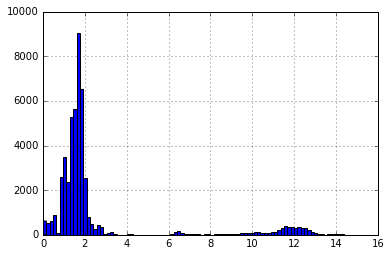

In [19]:
b=dfu.maxpss/1024/1024
b.hist(bins=100)

In [20]:
dfu.memory_usage()

Index                     80
batchid               419176
computingelement      419176
computingsite         419176
corecount             419176
cpuconsumptiontime    419176
creationtime          419176
endtime               419176
maxpss                419176
maxrss                419176
modificationhost      419176
pandaid               419176
starttime             419176
wall_time             419176
dtype: int64

In [21]:
dfu.to_csv('./ev_example_161516_all.csv')